# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning)

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Apr  3 18:43:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-03 18:43:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-03 18:43:17 (88.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-03 18:43:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.3MB/s    in 38s     

2023-04-03 18:44:00 (40.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "/content/101_food_classes_10_percent/train/"
test_dir = "/content/101_food_classes_10_percent/test/"

In [ ]:
# How many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 im

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=32)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                shuffle=False) # don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
tf.__version__

'2.12.0'

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augumentation layer to build data augumentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Fature extract for 5 full passes (5 epochs on the train dataset and valiadion on 15% of the test data, to save epoch time)


In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augumentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augumentation
data_augumentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # we can skip Rescaling layer because efficientnet has it built in
])

In [ ]:
# Setup the input shape and base model and freeze its layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augumentation
x = data_augumentation(inputs)

# Give base model the inputs after augumentation and don't train it
x = base_model(x, training=False)

# Pool output layer
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Set up a dense layer as an output
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
# Fit the model
history_1_101_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                               steps_per_epoch=len(train_data_all_10_percent),
                                               epochs=5,
                                               validation_data=test_data,
                                               validation_steps=int(0.15 * len(test_data)),
                                               callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 101s 366ms/step - loss: 3.3945 - accuracy: 0.2684 - val_loss: 2.5518 - val_accuracy: 0.4383
Epoch 2/5
237/237 [==============================] - 69s 291ms/step - loss: 2.2110 - accuracy: 0.4965 - val_loss: 2.0999 - val_accuracy: 0.5003
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.8321 - accuracy: 0.5650 - val_loss: 1.9222 - val_accuracy: 0.5207
Epoch 4/5
237/237 [==============================] - 60s 251ms/step - loss: 1.6113 - accuracy: 0.6111 - val_loss: 1.8233 - val_accuracy: 0.5336
Epoch 5/5
237/237 [==============================] - 56s 233ms/step - loss: 1.4548 - accuracy: 0.6445 - val_loss: 1.8236 - val_accuracy: 0.5252


In [ ]:
# Evaluate the model on all of the data
model_1.evaluate(test_data)

790/790 [==============================] - 66s 84ms/step - loss: 1.5856 - accuracy: 0.5826


[1.5855580568313599, 0.5826138854026794]

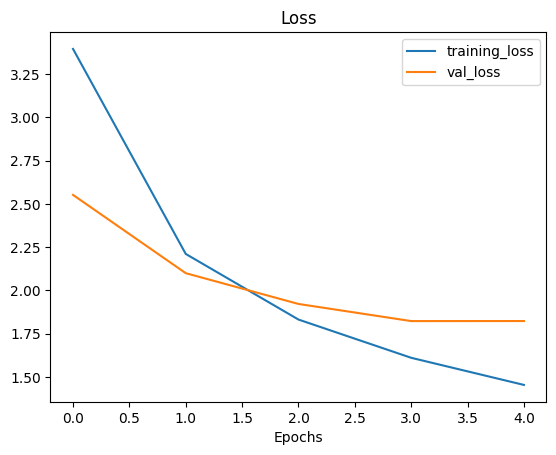

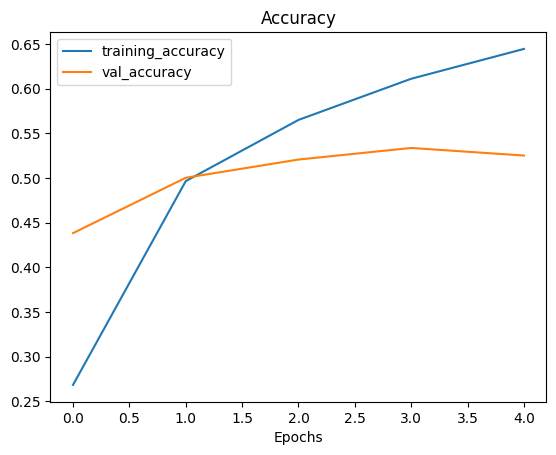

In [ ]:
# Plot loss curves
plot_loss_curves(history_1_101_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower learning rate when fine-tuning)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
# Check chich layer are trainable in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Fit the model continuing on last epoch from previous fit
history_2_101_classes_fine_tuning = model_1.fit(train_data_all_10_percent,
                                                steps_per_epoch=len(train_data_all_10_percent),
                                                epochs=fine_tune_epochs,
                                                initial_epoch=history_1_101_classes_10_percent.epoch[-1],
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 67s 246ms/step - loss: 1.2022 - accuracy: 0.6888 - val_loss: 1.7597 - val_accuracy: 0.5389
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.0965 - accuracy: 0.7094 - val_loss: 1.7400 - val_accuracy: 0.5463
Epoch 7/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0058 - accuracy: 0.7308 - val_loss: 1.7287 - val_accuracy: 0.5485
Epoch 8/10
237/237 [==============================] - 48s 203ms/step - loss: 0.9435 - accuracy: 0.7493 - val_loss: 1.7638 - val_accuracy: 0.5421
Epoch 9/10
237/237 [==============================] - 50s 206ms/step - loss: 0.8897 - accuracy: 0.7571 - val_loss: 1.7710 - val_accuracy: 0.5381
Epoch 10/10
237/237 [==============================] - 45s 189ms/step - loss: 0.8439 - accuracy: 0.7757 - val_loss: 1.7484 - val_accuracy: 0.5440


In [ ]:
model_1.evaluate(test_data)

790/790 [==============================] - 64s 81ms/step - loss: 1.5064 - accuracy: 0.6003


[1.506392002105713, 0.6002772450447083]

In [ ]:
# !pip install tensorflow==2.9.1

In [ ]:
model_1.save("/content/drive/MyDrive/saved_models/transfer-learning/101_classes_fine_tuning_efficient_net")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/transfer-learning/101_classes_fine_tuning_efficient_net")

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 71s 78ms/step - loss: 1.5064 - accuracy: 0.6003


[1.5063921213150024, 0.6002772450447083]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and find out which predictions were the "most" wrong

In [ ]:
import tensorflow as tf

# Download pretrained model, that was prepared earlier, so all predictions are similar
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-04-03 18:45:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.9MB/s    in 1.9s    

2023-04-03 18:45:56 (22.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Unzip the data
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 61s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 78ms/step


In [ ]:
# How many predicions are there
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [ ]:
# First prediction
preds_probs[0]

array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
       8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
       1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
       2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
       6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
       1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
       8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
       2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
       1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
       1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
       8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
       2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
       3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
       8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
       3.5306188e-05, 3.2488941e-05, 6.7314730e-05, 1.2852589e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed in to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilitt sample 0 looks like:\n{preds_probs[0]}\n")
print(f"Class with the highest predicted probability by the model for sample 0: {tf.argmax(preds_probs[0])}")

Number of prediction probabilities for sample 0: 101
What prediction probabilitt sample 0 looks like:
[5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1.0

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now we've got a predictions array of all of our model's predictions. In order to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

In [ ]:
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=16)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores...

In [ ]:
class_names = test_data.class_names

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [ ]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)

f1_scores[:10]

,class_names,f1_score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot f1_scores
def plot_f1_scores(f1_scores, figsize=(12, 6)):
  fig, ax = plt.subplots(figsize=figsize)

  ax.bar(f1_scores["class_names"], f1_scores["f1_score"])
  ax.set_ylabel("F1-score")
  ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
  plt.xticks(rotation=30, ha='right')

In [ ]:
plot_f1_scores(f1_scores, figsize=(42, 10))

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our dataset.

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image_resize()
* Scale the image to get all of the pixel values between 0 & 1

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image form filename, turns it into a tensor and reshapes into 
  specified shape (img_shape, img_shape, colour_channels=3)
  
  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img / 255.
  
  return img

Now we've got a function to load and prepare target images, let's write some code to visualize images, their target label and our model's predictions

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s along with the model's predictions, prediction probability and truth label.

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))

for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  
  # Plot the image(s)
  plt.subplot(3, 1, i + 1)
  plt.imshow(img / 255.)
  
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {(pred_prob.max() * 100):.2f}%",
            c=title_color)

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the image with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all image paths
filepaths = np.array([])

for filepath in tf.data.Dataset.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                           shuffle=False):
  filepaths = np.append(filepaths, filepath)

filepaths[:5]

array([b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
       b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
       b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
       b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
       b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg'],
      dtype=object)

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname": np.array([class_names[i] for i in y_labels]),
                        "y_pred_classname": np.array([class_names[i] for i in pred_classes])})

pred_df[735:755]

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
735,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.991258,baklava,baklava
736,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.998864,baklava,baklava
737,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.974502,baklava,baklava
738,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.995526,baklava,baklava
739,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.946621,baklava,baklava
740,b'/content/101_food_classes_10_percent/test/ba...,2,85,0.713646,baklava,samosa
741,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.500134,baklava,baklava
742,b'/content/101_food_classes_10_percent/test/ba...,2,97,0.362869,baklava,takoyaki
743,b'/content/101_food_classes_10_percent/test/ba...,2,12,0.442229,baklava,cannoli
744,b'/content/101_food_classes_10_percent/test/ba...,2,2,0.999984,baklava,baklava


In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658606,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib,False


In [ ]:
# 4. Sort our DataFrame to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
24540,b'/content/101_food_classes_10_percent/test/ti...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'/content/101_food_classes_10_percent/test/br...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'/content/101_food_classes_10_percent/test/pa...,71,65,0.999931,paella,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999904,sushi,sashimi,False


In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability

def plot_top_wrong_preds(pred_df, n_images):

  plt.figure(figsize=(12, 60))
  
  for i in range(n_images):
    plt.subplot(n_images, 1, i + 1)
    
    img = load_and_prep_image(pred_df.iloc[i]["img_path"])
    true_class = pred_df.iloc[i]["y_true_classname"]
    pred_class = pred_df.iloc[i]["y_pred_classname"]
    pred_prob = pred_df.iloc[i]["pred_conf"]

    if true_class == pred_class:
      title_color = "g"
    else:
      title_color = "r"

    plt.imshow(img)
    plt.title(f"true: {true_class}, pred: {pred_class} ({(pred_prob * 100):.2f})", 
              fontsize=10,
              c=title_color)


In [ ]:
plot_top_wrong_preds(top_100_wrong, 10)

## Test out the big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-04-03 19:58:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  13.6MB/s    in 0.9s    

2023-04-03 19:58:20 (13.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg']

In [ ]:
# Make and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {(pred_prob.max() * 100):.2f}%")
  plt.axis(False);

# Exercises

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-04 07:27:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-04 07:27:24 (77.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-04 07:27:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.6MB/s    in 79s     

2023-04-04 07:29:01 (19.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
unzip_data("101_food_classes_10_percent.zip")

train_dir = "/content/101_food_classes_10_percent/train/"
test_dir = "/content/101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32,
                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
tf.__version__

'2.12.0'

In [8]:
# Create checkpoint callback
checkpoint_path = "/content/101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Create data augumentation layer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomZoom, RandomWidth, RandomHeight, RandomRotation, RandomFlip

data_augumentation = Sequential([
    RandomZoom(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomRotation(0.2),
    RandomFlip("horizontal")
])

In [11]:
# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augumentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=10,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/10
237/237 [==============================] - 121s 434ms/step - loss: 3.3716 - accuracy: 0.2766 - val_loss: 2.3042 - val_accuracy: 0.4801
Epoch 2/10
237/237 [==============================] - 103s 435ms/step - loss: 2.2028 - accuracy: 0.4976 - val_loss: 1.8666 - val_accuracy: 0.5424
Epoch 3/10
237/237 [==============================] - 92s 382ms/step - loss: 1.8438 - accuracy: 0.5615 - val_loss: 1.7035 - val_accuracy: 0.5614
Epoch 4/10
237/237 [==============================] - 84s 349ms/step - loss: 1.6353 - accuracy: 0.6004 - val_loss: 1.6184 - val_accuracy: 0.5794
Epoch 5/10
237/237 [==============================] - 76s 316ms/step - loss: 1.4775 - accuracy: 0.6367 - val_loss: 1.5798 - val_accuracy: 0.5794
Epoch 6/10
237/237 [==============================] - 74s 311ms/step - loss: 1.3573 - accuracy: 0.6636 - val_loss: 1.5519 - val_accuracy: 0.5879
Epoch 7/10
237/237 [==============================] - 72s 299ms/step - loss: 1.2557 - accuracy: 0.6899 - val_loss: 1.5355 - val_

In [13]:
# Evaluate model on full test dataset
result_1 = model.evaluate(test_data)

790/790 [==============================] - 75s 95ms/step - loss: 1.5142 - accuracy: 0.5931


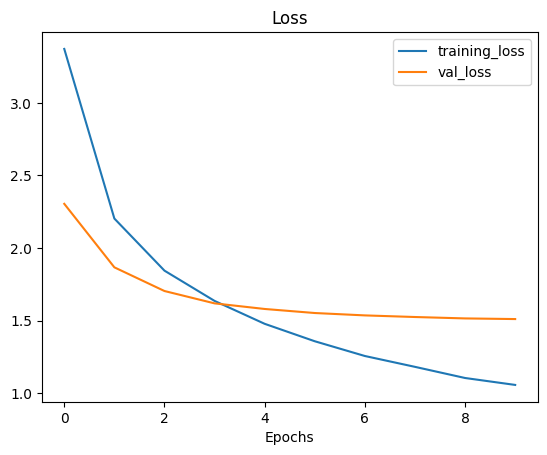

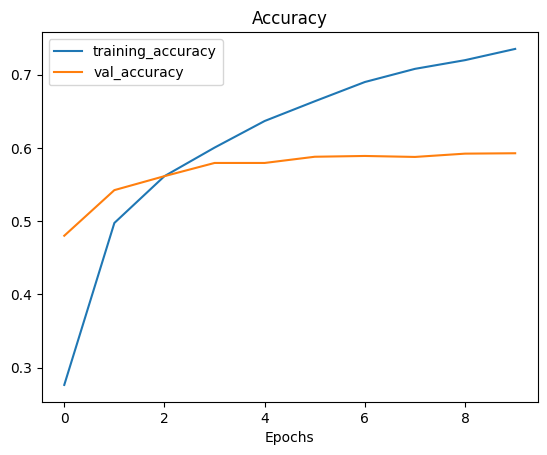

In [14]:
# Plot loss curves
plot_loss_curves(history)

## Fine tuning

Let's unfreeze top 20 layers and lower the learning rate

2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [15]:
# Unfreeze all the layrs in the base model
base_model.trainable = True

# Refreeze every layer except the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [19]:
# Recompile model and lower learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [20]:
# Fit the model from last epoch of previous fit
initial_epochs = 10
epochs = initial_epochs + 10

history_2 = model.fit(train_data,
                      steps_per_epoch=len(train_data),
                      epochs=epochs,
                      initial_epoch=history.epoch[-1],
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[checkpoint_callback])

Epoch 10/20
237/237 [==============================] - 64s 212ms/step - loss: 0.8670 - accuracy: 0.7630 - val_loss: 1.5374 - val_accuracy: 0.5959
Epoch 11/20
237/237 [==============================] - 48s 200ms/step - loss: 0.7207 - accuracy: 0.8000 - val_loss: 1.5614 - val_accuracy: 0.5998
Epoch 12/20
237/237 [==============================] - 43s 176ms/step - loss: 0.6187 - accuracy: 0.8276 - val_loss: 1.5910 - val_accuracy: 0.5990
Epoch 13/20
237/237 [==============================] - 43s 178ms/step - loss: 0.5453 - accuracy: 0.8422 - val_loss: 1.6211 - val_accuracy: 0.6030
Epoch 14/20
237/237 [==============================] - 42s 175ms/step - loss: 0.4792 - accuracy: 0.8663 - val_loss: 1.6632 - val_accuracy: 0.6012
Epoch 15/20
237/237 [==============================] - 42s 176ms/step - loss: 0.4299 - accuracy: 0.8759 - val_loss: 1.6954 - val_accuracy: 0.5988
Epoch 16/20
237/237 [==============================] - 43s 179ms/step - loss: 0.3744 - accuracy: 0.8943 - val_loss: 1.7239 -

In [17]:
# Evaluate model on full test dataset
result_2 = model.evaluate(test_data)

790/790 [==============================] - 66s 82ms/step - loss: 1.5142 - accuracy: 0.5931


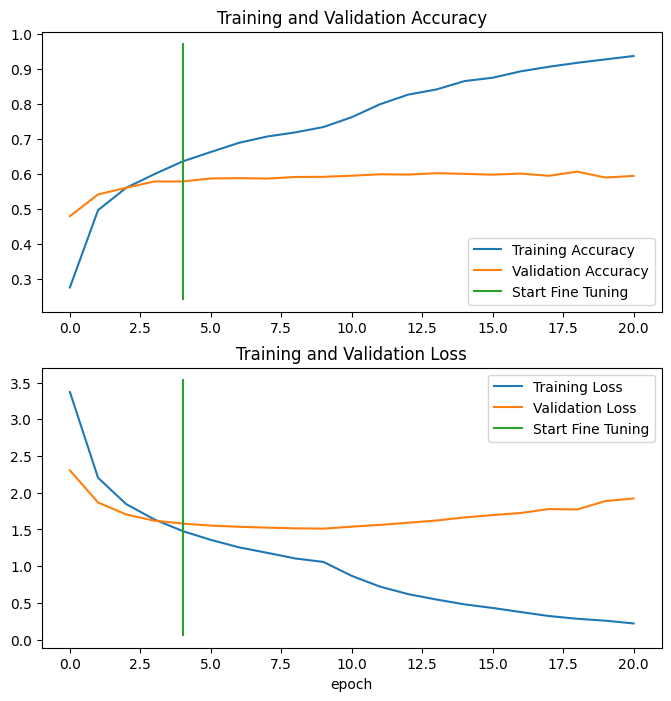

In [21]:
# Compare historys
compare_historys(history, history_2)

Let's now unfreeze top 30 layers and again lower the learning rate

3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [22]:
# Unfreeze all layers
base_model.trainable = True

# Freeze all the layers except top 30
for layer in base_model.layers[:-30]:
  layer.trainable = True

In [23]:
# Recompile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
              metrics=["accuracy"])

In [26]:
initial_epochs = 20
epochs = initial_epochs + 10

# Fit the model
history_3 = model.fit(train_data,
                      steps_per_epoch=len(train_data),
                      epochs=epochs,
                      initial_epoch=history_2.epoch[-1],
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[checkpoint_callback])

Epoch 20/30
237/237 [==============================] - 297s 1s/step - loss: 0.1850 - accuracy: 0.9469 - val_loss: 1.9647 - val_accuracy: 0.6020
Epoch 21/30
237/237 [==============================] - 204s 857ms/step - loss: 0.1574 - accuracy: 0.9554 - val_loss: 1.9667 - val_accuracy: 0.6038
Epoch 22/30
237/237 [==============================] - 173s 729ms/step - loss: 0.1312 - accuracy: 0.9622 - val_loss: 1.9905 - val_accuracy: 0.6046
Epoch 23/30
237/237 [==============================] - 170s 714ms/step - loss: 0.1227 - accuracy: 0.9671 - val_loss: 2.0690 - val_accuracy: 0.6110
Epoch 24/30
237/237 [==============================] - 144s 605ms/step - loss: 0.1283 - accuracy: 0.9633 - val_loss: 2.0051 - val_accuracy: 0.6133
Epoch 25/30
237/237 [==============================] - 141s 593ms/step - loss: 0.0934 - accuracy: 0.9757 - val_loss: 2.0382 - val_accuracy: 0.6160
Epoch 26/30
237/237 [==============================] - 137s 576ms/step - loss: 0.0892 - accuracy: 0.9760 - val_loss: 2.19

In [27]:
# Evaluate on full test data
result_3 = model.evaluate(test_data)

790/790 [==============================] - 73s 92ms/step - loss: 2.2342 - accuracy: 0.6022


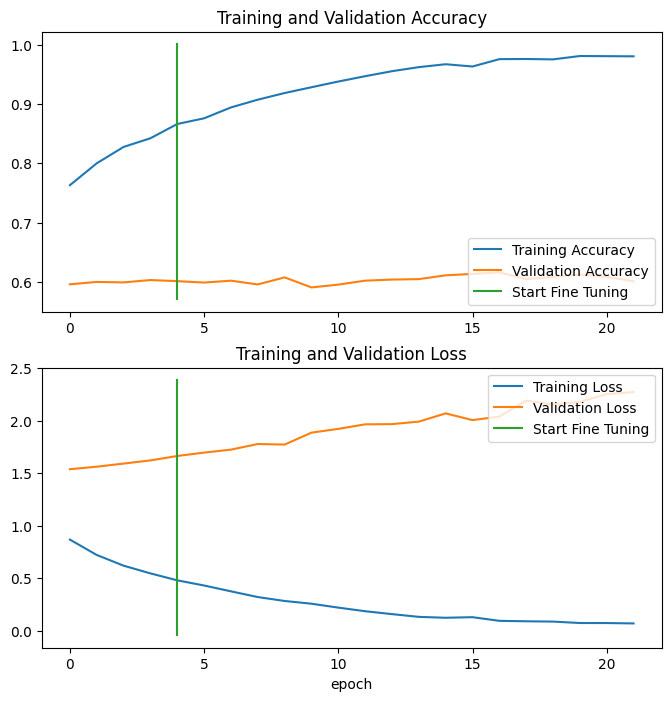

In [28]:
# Compare historys
compare_historys(history_2, history_3)